In [7]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns

## Enhance Raw Data

In [8]:
df = pd.read_csv("../data/final_dataset_mest.csv")

In [9]:
# unifying calculations (per km^2)
df['crime_density'] = df['crime_total'] / df['area_km2']
df['crime_attractor_density'] = (df['poi_pub'] + df['poi_nightclub'] + df['poi_bar']) / df['area_km2']
df['crime_generator_density'] = (df['poi_cafe'] + df['poi_museum'] + df['poi_attraction']) / df['area_km2']
df['tourist_density'] = df['nights_non_residents'] / df['area_km2']
df['foreigner_density'] = df['foreigners'] / df['area_km2']
df['university_density'] = df['people_university'] / df['area_km2']
df['airbnb_economy_density'] = df['airbnb_economy'] / df['area_km2']

In [10]:
# handle NaN values
df = df.fillna(0.0)

# Economy vs Luxury Airbnb Density

#### Construct Simple OLS Models

1. we predict crime_density in each Prague district
2. separate so called crime attractors (bars, pubs, nightclubs) and crime generators (cafes, museums, atractions) into two separated models
3. remove variables that are most likely multicolinear with crime_density (crime_total, crime_Burglary, crime_Disorder, crime_Other, crime_Theft,...)

In [11]:
lm_crime_economy = smf.ols('crime_density ~ dist_center_km + airbnb_economy_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=df).fit()

lm_crime_luxury = smf.ols('crime_density ~ dist_center_km + airbnb_luxury_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=df).fit()

## Outliers

#### Analysing Outliers

Outliers of economy model: [ 0  2  8 11 15 19 21 46 56]
Outliers of luxury model: [ 0  2  4  8 11 15 19 21 46 56]


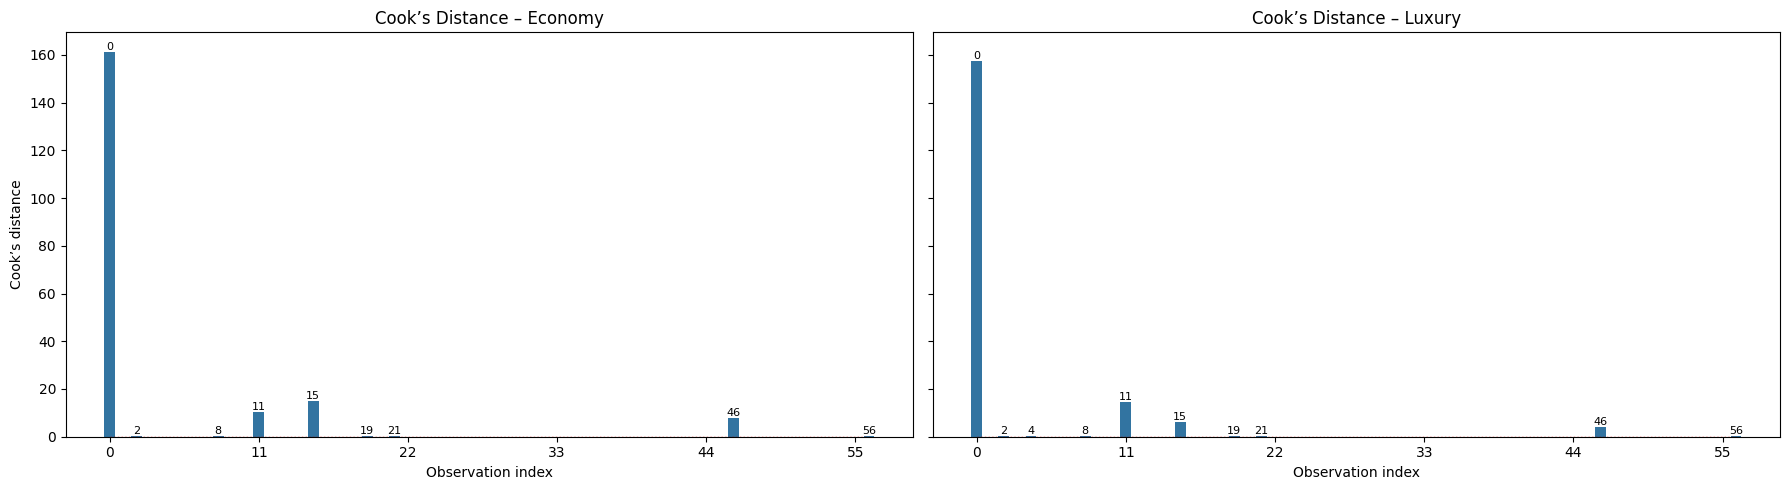

In [12]:
# Outliers detection using Cook's distance
influence_economy = lm_crime_economy.get_influence()
n = int(lm_crime_economy.nobs)
cooks_d_economy = influence_economy.cooks_distance[0]
outliers_economy = np.where(cooks_d_economy > 4 / n)[0]
print(f"Outliers of economy model: {outliers_economy}")

influence_luxury = lm_crime_luxury.get_influence()
n = int(lm_crime_luxury.nobs)
cooks_d_luxury = influence_luxury.cooks_distance[0]
outliers_luxury = np.where(cooks_d_luxury > 4 / n)[0]
print(f"Outliers of luxury model: {outliers_luxury}")

fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharey=True)

# economy plot
n_econ = len(cooks_d_economy)
x_econ = np.arange(n_econ)
ax = axes[0]
sns.barplot(x=x_econ, y=cooks_d_economy, ax=ax)
ax.plot(x_econ, np.full(n_econ, 4 / n_econ), linestyle="dotted", linewidth=1, color="red")

for o in outliers_economy:
    ax.text(o, cooks_d_economy[o] + 0.005, str(o), ha="center", va="bottom", fontsize=8)

ax.set_title("Cook’s Distance – Economy")
ax.set_xlabel("Observation index")
ax.set_ylabel("Cook’s distance")
ax.set_xticks(range(0, n_econ, max(1, n_econ // 5)))

# luxury plot
n_lux = len(cooks_d_luxury)
x_lux = np.arange(n_lux)
ax = axes[1]
sns.barplot(x=x_lux, y=cooks_d_luxury, ax=ax)
ax.plot(x_lux, np.full(n_lux, 4 / n_lux), linestyle="dotted", linewidth=1, color="red")

for o in outliers_luxury:
    ax.text(o, cooks_d_luxury[o] + 0.005, str(o), ha="center", va="bottom", fontsize=8)

ax.set_title("Cook’s Distance – Luxury")
ax.set_xlabel("Observation index")
ax.set_xticks(range(0, n_lux, max(1, n_lux // 5)))

# final plot
plt.tight_layout()
plt.show()

#### Removing Outliers

In [13]:
# same for the luxury and economy models
X_no_outliers = df.drop(outliers_economy)

In [14]:
# refit models without outliers
lm_crime_economy = smf.ols('crime_density ~ dist_center_km + airbnb_economy_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=X_no_outliers).fit()

lm_crime_luxury = smf.ols('crime_density ~ dist_center_km + airbnb_luxury_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=X_no_outliers).fit()

## Linearity and Homoscedasticity

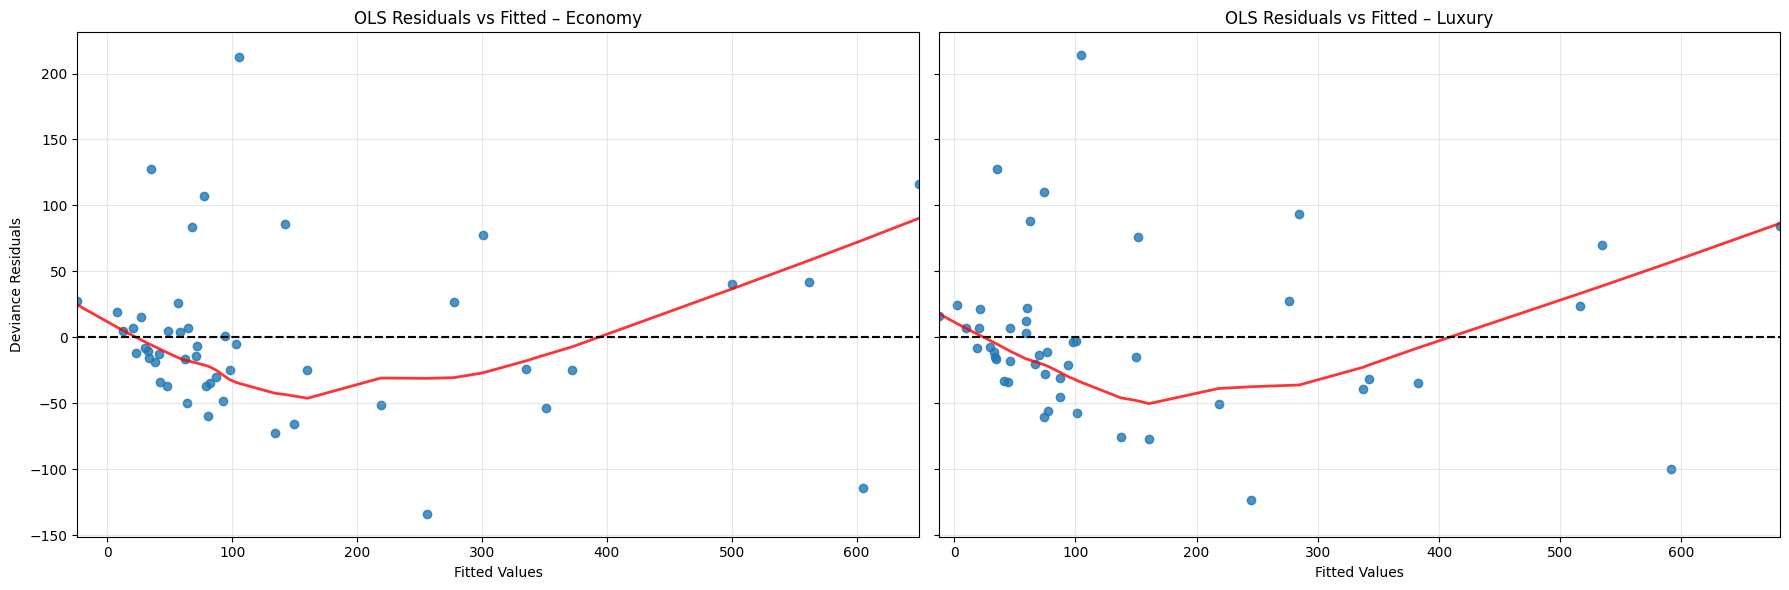

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# ---------- ECONOMY ----------
fitted_econ = lm_crime_economy.fittedvalues
resid_econ = lm_crime_economy.resid

sns.residplot(
    x=fitted_econ,
    y=resid_econ,
    lowess=True,
    line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8},
    ax=axes[0]
)

axes[0].axhline(0, color='black', linestyle='--')
axes[0].set_title('OLS Residuals vs Fitted – Economy')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Deviance Residuals')
axes[0].grid(True, alpha=0.3)


# ---------- LUXURY ----------
fitted_lux = lm_crime_luxury.fittedvalues
resid_lux = lm_crime_luxury.resid

sns.residplot(
    x=fitted_lux,
    y=resid_lux,
    lowess=True,
    line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8},
    ax=axes[1]
)

axes[1].axhline(0, color='black', linestyle='--')
axes[1].set_title('OLS Residuals vs Fitted – Luxury')
axes[1].set_xlabel('Fitted Values')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# remove more significant outliers
X_no_outliers = X_no_outliers.drop([30, 34, 39])

In [ ]:
# switch to GLM function for more convanient feature transformation

formula = ('np.log1p(crime_density) ~ dist_center_km + I(dist_center_km**2) + '
           'airbnb_economy_density + tourist_density + '
           'crime_attractor_density + crime_generator_density + '
           'foreigner_density + university_density + unemployment + mhd_density')

glm_log_economy = smf.glm(
    formula=formula, 
    data=X_no_outliers, 
    family=sm.families.InverseGaussian()
).fit()

print(glm_log_economy.summary())
glm_log_economy.aic


                    Generalized Linear Model Regression Results                    
Dep. Variable:     np.log1p(crime_density)   No. Observations:                   45
Model:                                 GLM   Df Residuals:                       34
Model Family:              InverseGaussian   Df Model:                           10
Link Function:              InverseSquared   Scale:                        0.011811
Method:                               IRLS   Log-Likelihood:                -57.301
Date:                     Sun, 28 Dec 2025   Deviance:                      0.45968
Time:                             23:37:42   Pearson chi2:                    0.402
No. Iterations:                          7   Pseudo R-squ. (CS):             0.6795
Covariance Type:                 nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

np.float64(136.6011182697528)

In [ ]:
formula = ('np.log1p(crime_density) ~ dist_center_km + I(dist_center_km**2) + '
           'airbnb_luxury_density + tourist_density + '
           'crime_attractor_density + crime_generator_density + '
           'foreigner_density + university_density + unemployment + mhd_density')

glm_log_luxury = smf.glm(
    formula=formula, 
    data=X_no_outliers, 
    family=sm.families.InverseGaussian()
).fit()

print(glm_log_luxury.summary())
glm_log_luxury.aic

                    Generalized Linear Model Regression Results                    
Dep. Variable:     np.log1p(crime_density)   No. Observations:                   45
Model:                                 GLM   Df Residuals:                       34
Model Family:              InverseGaussian   Df Model:                           10
Link Function:              InverseSquared   Scale:                        0.011823
Method:                               IRLS   Log-Likelihood:                -57.151
Date:                     Sun, 28 Dec 2025   Deviance:                      0.45607
Time:                             23:37:42   Pearson chi2:                    0.402
No. Iterations:                          7   Pseudo R-squ. (CS):             0.6814
Covariance Type:                 nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

np.float64(136.30122994056512)

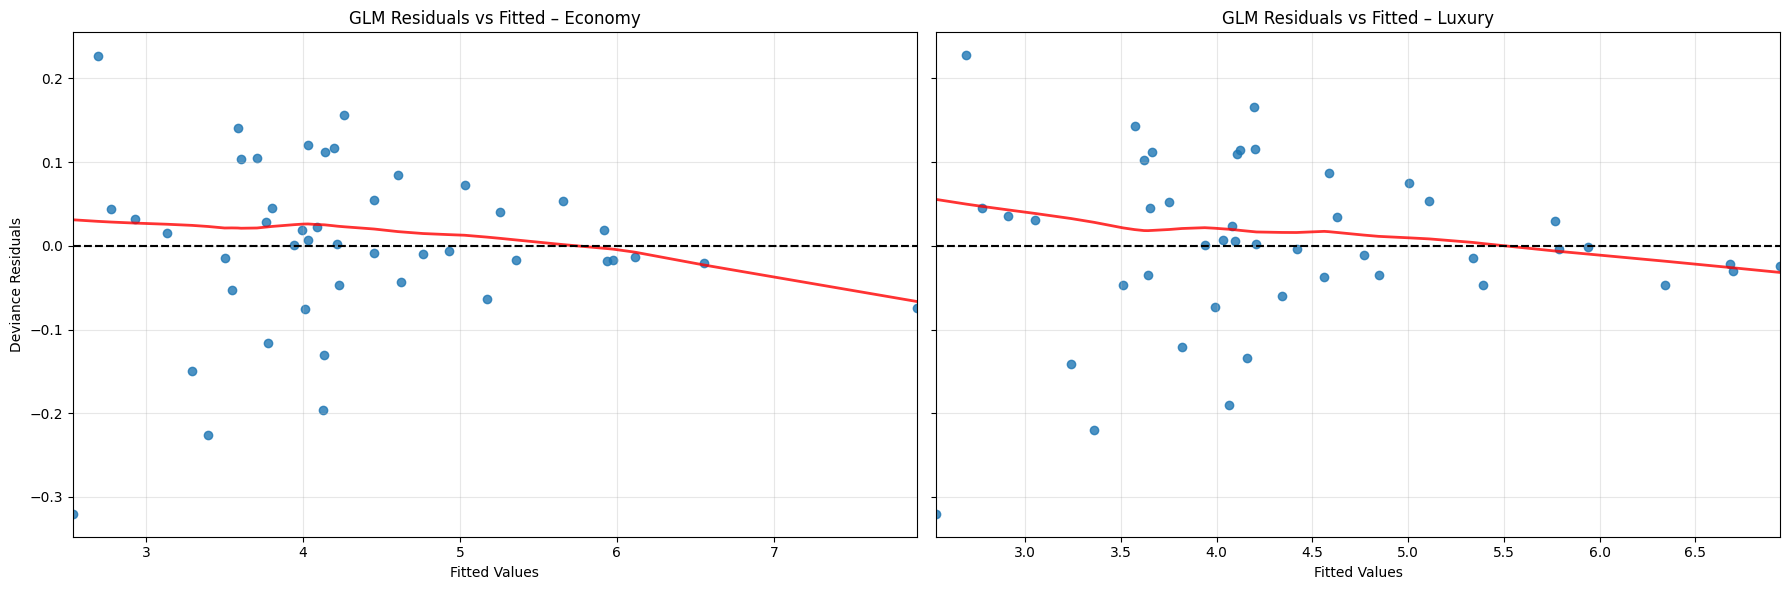

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# economy
fitted_econ = glm_log_economy.mu
resid_econ = glm_log_economy.resid_deviance

sns.residplot(
    x=fitted_econ,
    y=resid_econ,
    lowess=True,
    line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8},
    ax=axes[0]
)

axes[0].axhline(0, color='black', linestyle='--')
axes[0].set_title('GLM Residuals vs Fitted – Economy')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Deviance Residuals')
axes[0].grid(True, alpha=0.3)


# luxury
fitted_lux = glm_log_luxury.mu
resid_lux = glm_log_luxury.resid_deviance

sns.residplot(
    x=fitted_lux,
    y=resid_lux,
    lowess=True,
    line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8},
    ax=axes[1]
)

axes[1].axhline(0, color='black', linestyle='--')
axes[1].set_title('GLM Residuals vs Fitted – Luxury')
axes[1].set_xlabel('Fitted Values')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Good enough, no need to do spline or something.
Current transformation is "good enough" structurally. The remaining "wiggles" in the red line are likely noise, not a structural trend that a Spline would fix better than the current setup

In [20]:
# Homoscedasticity tests

_, pval, __, ___ = het_breuschpagan(glm_log_economy.resid_deviance, glm_log_economy.model.exog)
print(f"Breusch-Pagan p-value - economy airbnb: {pval}")

_, pval, __, ___ = het_breuschpagan(glm_log_luxury.resid_deviance, glm_log_luxury.model.exog)
print(f"Breusch-Pagan p-value - luxury airbnb: {pval}")

Breusch-Pagan p-value - economy airbnb: 0.05574756585010101
Breusch-Pagan p-value - luxury airbnb: 0.05093300195768567


Breusch-Pagan test proved that the current model is accaptable for further studies since the p-values are not that far from the line p-value = 0.05 for rejecting the H0.

## Multicollinearity and Feature Selection

#### Correlation Matrix

In [21]:
features_economy = ['dist_center_km', 'airbnb_economy_density', 'tourist_density', 
            'crime_attractor_density', 'crime_generator_density', 
            'foreigner_density', 'university_density', 'unemployment', 'mhd_density']

corr_matrix_economy = X_no_outliers[features_economy].corr()

features_luxury = ['dist_center_km', 'airbnb_luxury_density', 'tourist_density', 
            'crime_attractor_density', 'crime_generator_density', 
            'foreigner_density', 'university_density', 'unemployment', 'mhd_density']

corr_matrix_luxury = X_no_outliers[features_luxury].corr()

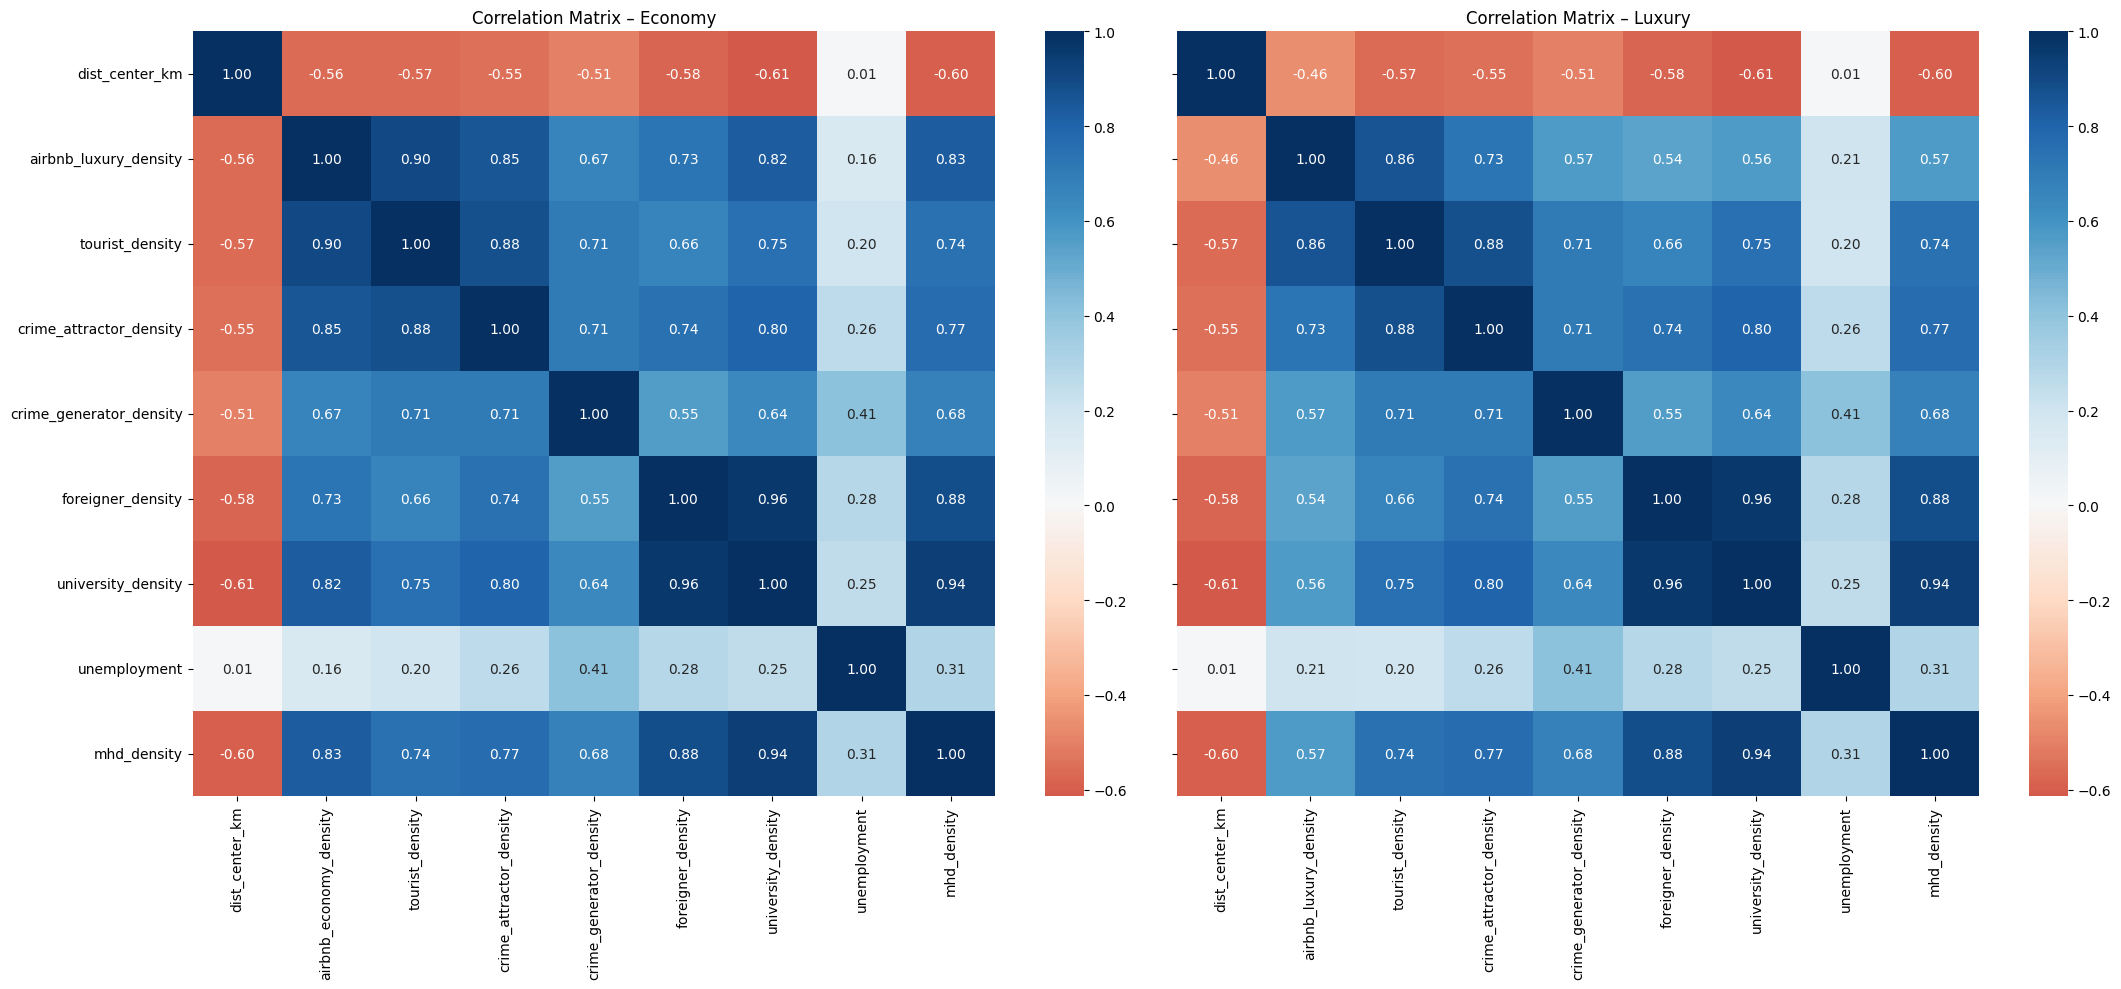

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(22, 10), sharey=True)

# economy
sns.heatmap(
    corr_matrix_economy,
    annot=True,
    cmap='RdBu',
    center=0,
    fmt=".2f",
    ax=axes[0]
)
axes[0].set_title("Correlation Matrix – Economy")

# luxury
sns.heatmap(
    corr_matrix_luxury,
    annot=True,
    cmap='RdBu',
    center=0,
    fmt=".2f",
    ax=axes[1]
)
axes[1].set_title("Correlation Matrix – Luxury")

plt.tight_layout()
plt.show()

#### VIF Factor

In [23]:
# economy
X_vif_economy = X_no_outliers[features_economy].copy()
X_vif_economy['intercept'] = 1

vif_data_economy = pd.DataFrame()
vif_data_economy["feature"] = X_vif_economy.columns
vif_data_economy["VIF"] = [variance_inflation_factor(X_vif_economy.values, i) for i in range(len(X_vif_economy.columns))]

# luxury
X_vif_luxury = X_no_outliers[features_luxury].copy()
X_vif_economy['intercept'] = 1

vif_data_luxury = pd.DataFrame()
vif_data_luxury["feature"] = X_vif_luxury.columns
vif_data_luxury["VIF"] = [variance_inflation_factor(X_vif_luxury.values, i) for i in range(len(X_vif_luxury.columns))]


In [24]:
print("\nEconomy Airbnb VIFs:\n")
print(vif_data_economy.sort_values(by="VIF", ascending=False))

print("\Luxury Airbnb VIFs:\n")
print(vif_data_economy.sort_values(by="VIF", ascending=False))


Economy Airbnb VIFs:

                   feature        VIF
9                intercept  39.329337
6       university_density  28.996173
5        foreigner_density  15.117340
8              mhd_density  10.214547
1   airbnb_economy_density   8.308187
2          tourist_density   7.716321
3  crime_attractor_density   5.790172
4  crime_generator_density   2.875791
0           dist_center_km   1.914470
7             unemployment   1.569770
\Luxury Airbnb VIFs:

                   feature        VIF
9                intercept  39.329337
6       university_density  28.996173
5        foreigner_density  15.117340
8              mhd_density  10.214547
1   airbnb_economy_density   8.308187
2          tourist_density   7.716321
3  crime_attractor_density   5.790172
4  crime_generator_density   2.875791
0           dist_center_km   1.914470
7             unemployment   1.569770


<>:4: SyntaxWarning: invalid escape sequence '\L'
<>:4: SyntaxWarning: invalid escape sequence '\L'
/home/teruna/tmp/ipykernel_85544/1141579644.py:4: SyntaxWarning: invalid escape sequence '\L'
  print("\Luxury Airbnb VIFs:\n")


In [25]:
# TODO: add comment to corr matrix and VIF values

#### Removing multicollinearity

##### Stepwise Dropping Features

In [26]:
def stepwise_feature_selection(df, list_of_features, threshold=5.0):
    """
    Automatically drops the variable with the highest VIF 
    until all remaining variables are below the threshold.
    """
    while True:

        X = df[list_of_features].copy()
        X['intercept'] = 1
        
        vif = pd.DataFrame()
        vif["feature"] = X.columns
        vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
        vif = vif[vif['feature'] != 'intercept'].sort_values('VIF', ascending=False)
        
        max_vif = vif.iloc[0]['VIF']
        if max_vif > threshold:
            if vif.iloc[0]['feature'] == 'airbnb_economy_density':
                target = vif.iloc[1]['feature']
            else:
                target = vif.iloc[0]['feature']
                
            print(f"Dropping {target} with VIF {max_vif:.2f}")
            list_of_features.remove(target)
        else:
            break
            
    return list_of_features, vif


In [27]:
# Run the selection
final_features_economy, final_vif_table_economy = stepwise_feature_selection(X_no_outliers, features_economy)
print("\nFinal VIF Table:\n", final_vif_table_economy)

final_features_luxury, final_vif_table_luxury = stepwise_feature_selection(X_no_outliers, features_luxury)
print("\nFinal VIF Table:\n", final_vif_table_luxury)

Dropping university_density with VIF 29.00
Dropping tourist_density with VIF 8.18
Dropping mhd_density with VIF 7.38

Final VIF Table:
                    feature       VIF
2  crime_attractor_density  4.563369
1   airbnb_economy_density  4.289009
4        foreigner_density  2.840978
3  crime_generator_density  2.594595
0           dist_center_km  1.846605
5             unemployment  1.452514
Dropping university_density with VIF 34.57
Dropping tourist_density with VIF 9.86
Dropping mhd_density with VIF 5.97

Final VIF Table:
                    feature       VIF
2  crime_attractor_density  4.059385
4        foreigner_density  2.610705
3  crime_generator_density  2.487304
1    airbnb_luxury_density  2.162125
0           dist_center_km  1.861247
5             unemployment  1.384628


##### Ridge Regression

In [28]:
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV

X_economy = X_no_outliers[features_economy]
y_economy = np.log1p(X_no_outliers['crime_density'])

X_luxury = X_no_outliers[features_luxury]
y_luxury = np.log1p(X_no_outliers['crime_density'])



In [29]:
ridge_model = RidgeCV(alphas=np.logspace(-6, 6, 13))
ridge_model.fit(X_economy, y_economy)

# Create a summary of coefficients
ridge_coefs = pd.Series(ridge_model.coef_, index=features_economy).sort_values(ascending=False)
print("Best Alpha for Ridge:", ridge_model.alpha_)
print("\nRidge Coefficients:\n", ridge_coefs)

#-------------------------------------------------------------------------------------------------

ridge_model = RidgeCV(alphas=np.logspace(-6, 6, 13))
ridge_model.fit(X_luxury, y_luxury)

# Create a summary of coefficients
ridge_coefs = pd.Series(ridge_model.coef_, index=features_luxury).sort_values(ascending=False)
print("Best Alpha for Ridge:", ridge_model.alpha_)
print("\nRidge Coefficients:\n", ridge_coefs)

Best Alpha for Ridge: 100.0

Ridge Coefficients:
 crime_generator_density    0.030508
airbnb_economy_density     0.007648
foreigner_density          0.001774
unemployment              -0.013638
crime_attractor_density   -0.018538
dist_center_km            -0.069686
dtype: float64
Best Alpha for Ridge: 100.0

Ridge Coefficients:
 crime_generator_density    0.030838
airbnb_luxury_density      0.006438
foreigner_density          0.001783
unemployment              -0.013816
crime_attractor_density   -0.018170
dist_center_km            -0.069838
dtype: float64


##### Lasso Regression

In [30]:
lasso_model = LassoCV(alphas=None, cv=10, max_iter=10000)
lasso_model.fit(X_economy, y_economy)

lasso_coefs = pd.Series(lasso_model.coef_, index=features_economy).sort_values(ascending=False)
print("Best Alpha for Lasso:", lasso_model.alpha_)
print("\nLasso Coefficients (Variables at 0 are excluded):\n", lasso_coefs)

lasso_model = LassoCV(alphas=None, cv=10, max_iter=10000)
lasso_model.fit(X_luxury, y_luxury)

lasso_coefs = pd.Series(lasso_model.coef_, index=features_luxury).sort_values(ascending=False)
print("Best Alpha for Lasso:", lasso_model.alpha_)
print("\nLasso Coefficients (Variables at 0 are excluded):\n", lasso_coefs)

Best Alpha for Lasso: 0.3869107818570125

Lasso Coefficients (Variables at 0 are excluded):
 foreigner_density          0.001919
airbnb_economy_density     0.000000
crime_generator_density    0.000000
crime_attractor_density   -0.000000
unemployment              -0.000000
dist_center_km            -0.045836
dtype: float64
Best Alpha for Lasso: 0.3869107818570125

Lasso Coefficients (Variables at 0 are excluded):
 foreigner_density          0.001919
airbnb_luxury_density      0.000000
crime_generator_density    0.000000
crime_attractor_density   -0.000000
unemployment              -0.000000
dist_center_km            -0.045835
dtype: float64


/home/teruna/Documents/cvut_fel/engineer/san/semestral_work/SAN/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1682: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
/home/teruna/Documents/cvut_fel/engineer/san/semestral_work/SAN/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1682: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(


No significant difference between economy and luxury airbnb density in the areas was proven.

In [ ]:
# TODO: clustering
# TODO: dimensionality reduction
# TODO: add comments to feature selection